# See Detailed code at https://github.com/aayush9753/ColorIt

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Importing Libraries

In [4]:
import glob
import random
import os
import numpy as np

import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torch import nn
from matplotlib import pyplot as plt

#from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

import argparse
import os
import numpy as np
import math
import itertools
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable

#from models import *
#from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch


from torchvision.models import vgg19

from skimage import color
from IPython import embed

## Util

In [5]:
def load_img(img_path):
	out_np = np.asarray(Image.open(img_path))
	if(out_np.ndim==2):
		out_np = np.tile(out_np[:,:,None],3)
	return out_np

def resize_img(img, HW=(256,256), resample=3):
	return np.asarray(Image.fromarray(img).resize((HW[1],HW[0]), resample=resample))

def preprocess_img(img_rgb_orig, HW=(256,256), resample=3):
	# return original size L and resized L as torch Tensors
	img_rgb_rs = resize_img(img_rgb_orig, HW=HW, resample=resample)
	
	img_lab_orig = color.rgb2lab(img_rgb_orig)
	img_lab_rs = color.rgb2lab(img_rgb_rs)

	img_l_orig = img_lab_orig[:,:,0]
	img_l_rs = img_lab_rs[:,:,0]

	tens_orig_l = torch.Tensor(img_l_orig)[None,None,:,:]
	tens_rs_l = torch.Tensor(img_l_rs)[None,None,:,:]

	return (tens_orig_l, tens_rs_l)

def postprocess_tens_new(tens_orig_l, out_ab, mode='bilinear'):
	# tens_orig_l 	Batchsize x 1 x H_orig x W_orig
	# out_ab 		Batchsize x 2 x H x W
    Batchsize = tens_orig_l.shape[0]

    output_ = []
    for i in range(Batchsize):
        tens_orig_l_i = tens_orig_l[i][np.newaxis, :, :, :]
        out_ab_i  = out_ab[i][np.newaxis, :, :, :]
        HW_orig_i = tens_orig_l_i.shape[2:]
        HW_i = out_ab_i.shape[2:]

        # call resize function if needed
        if(HW_orig_i[0]!=HW_i[0] or HW_orig_i[1]!=HW_i[1]):
            out_ab_orig_i = F.interpolate(out_ab_i, size=HW_orig_i, mode='bilinear')
        else:
            out_ab_orig_i = out_ab_i

        out_lab_orig_i = torch.cat((tens_orig_l_i, out_ab_orig_i), dim=1)
        #output_.append(color.lab2rgb(out_lab_orig_i.data.cpu().numpy()[0,...].transpose((1,2,0))))
        output_.append(color.lab2rgb(out_lab_orig_i.data.cpu().numpy()[0,...].transpose((1,2,0))).transpose((2,0,1)))
    return np.array(output_)

# Models
## ECV16
This Model is based on the paper Colorful Image Colorization https://arxiv.org/abs/1603.08511 which we will train using a GAN with the ECV Model (A normal residual convnet model proposed in the paper) as the generator and a discriminator that we will design.

In [6]:
class BaseColor(nn.Module):
	def __init__(self):
		super(BaseColor, self).__init__()

		self.l_cent = 50.
		self.l_norm = 100.
		self.ab_norm = 110.

	def normalize_l(self, in_l):
		return (in_l-self.l_cent)/self.l_norm

	def unnormalize_l(self, in_l):
		return in_l*self.l_norm + self.l_cent

	def normalize_ab(self, in_ab):
		return in_ab/self.ab_norm

	def unnormalize_ab(self, in_ab):
		return in_ab*self.ab_norm


class ECCVGenerator(BaseColor):
    def __init__(self, norm_layer=nn.BatchNorm2d):
        super(ECCVGenerator, self).__init__()

        model1=[nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=True),]
        model1+=[nn.ReLU(True),]
        model1+=[norm_layer(64),]

        model2=[nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1, bias=True),]
        model2+=[nn.ReLU(True),]
        model2+=[norm_layer(128),]

        model3=[nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=True),]
        model3+=[nn.ReLU(True),]
        model3+=[norm_layer(256),]

        model4=[nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model4+=[nn.ReLU(True),]
        model4+=[norm_layer(512),]

        model5=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model5+=[nn.ReLU(True),]
        model5+=[norm_layer(512),]

        model6=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[nn.Conv2d(512, 512, kernel_size=3, dilation=2, stride=1, padding=2, bias=True),]
        model6+=[nn.ReLU(True),]
        model6+=[norm_layer(512),]

        model7=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=True),]
        model7+=[nn.ReLU(True),]
        model7+=[norm_layer(512),]

        model8=[nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]
        model8+=[nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=True),]
        model8+=[nn.ReLU(True),]

        model8+=[nn.Conv2d(256, 313, kernel_size=1, stride=1, padding=0, bias=True),]

        self.model1 = nn.Sequential(*model1)
        self.model2 = nn.Sequential(*model2)
        self.model3 = nn.Sequential(*model3)
        self.model4 = nn.Sequential(*model4)
        self.model5 = nn.Sequential(*model5)
        self.model6 = nn.Sequential(*model6)
        self.model7 = nn.Sequential(*model7)
        self.model8 = nn.Sequential(*model8)

        self.softmax = nn.Softmax(dim=1)
        self.model_out = nn.Conv2d(313, 2, kernel_size=1, padding=0, dilation=1, stride=1, bias=False)
        self.upsample4 = nn.Upsample(scale_factor=4, mode='bilinear')

    def forward(self, input_l):
        conv1_2 = self.model1(self.normalize_l(input_l))
        conv2_2 = self.model2(conv1_2)
        conv3_3 = self.model3(conv2_2)
        conv4_3 = self.model4(conv3_3)
        conv5_3 = self.model5(conv4_3)
        conv6_3 = self.model6(conv5_3)
        conv7_3 = self.model7(conv6_3)
        conv8_3 = self.model8(conv7_3)
        out_reg = self.model_out(self.softmax(conv8_3))

        return self.unnormalize_ab(self.upsample4(out_reg))

def eccv16(pretrained=True):
	model = ECCVGenerator()
	if(pretrained):
		import torch.utils.model_zoo as model_zoo
		model.load_state_dict(model_zoo.load_url('https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth',map_location='cpu',check_hash=True))
	return model


## Feature Extractor
This is a noval approach to compare to images and use that comparison as a loss to train a model.
We will use a pre-trained VGG19 model. Two images are passed in it and the activations of the 18th layers are taken for both the images and then this activations are used to calculate the loss which can be calculated using RMSE, MSE etc between the two activations.

In [7]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)

## Discriminator
Takes an image as input and converts it into a single no. after passing through several convolutional blocks.

In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

# Image Dataset

In [9]:
batch_size = 4
n_cpu = 0
out_channels = 3

class ImageDataset(Dataset):
    def __init__(self, root, transform): #, shape):
        #height, width = shape
        self.transform = transform

        self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        
        black_path = self.files[index % len(self.files)]
        color_path = black_path.replace('black','color')
        
        img_black = np.asarray(Image.open(black_path))
        if(img_black.ndim==2):
            img_black = np.tile(img_black[:,:,None],3)
        (tens_l_orig, tens_l_rs) = preprocess_img(img_black, HW=(400, 400))
        #img_bw = postprocess_tens(tens_l_orig, torch.cat((0*tens_l_orig,0*tens_l_orig),dim=1))
        #img_black = self.transform(img_black)
        
        
        img_color = Image.open(color_path)
        img_color = self.transform(img_color)

        return {"black": tens_l_rs.squeeze(0), 'orig': tens_l_orig.squeeze(0), "color": img_color}


    def __len__(self):
        return len(self.files)

root = '../input/image-colorization-dataset/data/train_black/'
transform = transforms.Compose(
            [
                #transforms.Resize((shape[0], shape[1]), Image.BICUBIC),
                transforms.ToTensor(),
                #transforms.Normalize(mean, std),
            ]
        )
dataloader = DataLoader(
    ImageDataset(root, transform),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

torch.Size([400, 400, 1])


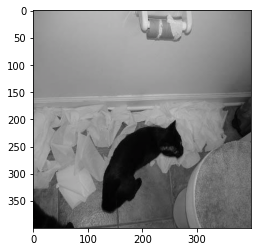

torch.Size([400, 400, 1])


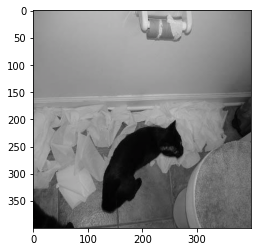

torch.Size([400, 400, 1])


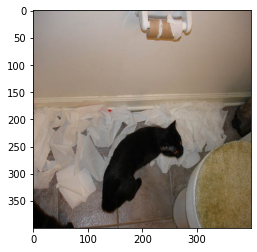

In [10]:
dataiter = iter(dataloader)
data = dataiter.next()

i = 1
img = data['black'][i].permute(1, 2, 0)
print(img.shape)
t = np.zeros((400, 400, 3))
t[..., 0] = img[..., 0]
t = color.lab2rgb(t)
plt.imshow(t)
plt.show()

img = data['orig'][i].permute(1, 2, 0)
print(img.shape)
t = np.zeros((400, 400, 3))
t[..., 0] = img[..., 0]
t = color.lab2rgb(t)
plt.imshow(t)
plt.show()

print(img.shape)
img = data['color'][i].permute(1, 2, 0)
plt.imshow(img)
plt.show()

# Initialising Models and Training Params

In [11]:
class color_ecv(nn.Module):
    def __init__(self, in_channels):
        super(color_ecv, self).__init__()
        
        self.model = eccv16(pretrained=True)
    
    def forward(self, x):
        ecv_output = self.model(x)
        return ecv_output

In [12]:
os.makedirs("colorit_gan/images", exist_ok=True)
os.makedirs("colorit_gan/saved_models", exist_ok=True)

In [13]:
start_epoch = 0
n_epochs= 50

lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
in_channels = 1
out_channels = 3
sample_interval = 100
checkpoint_interval = 1

cuda = torch.cuda.is_available()

In [14]:
shape = (400, 400)

# Initialize generator and discriminator
generator = color_ecv(in_channels = 3)
discriminator = Discriminator(input_shape=(out_channels, *shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()

if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

Downloading: "https://colorizers.s3.us-east-2.amazonaws.com/colorization_release_v2-9b330a0b.pth" to /root/.cache/torch/hub/checkpoints/colorization_release_v2-9b330a0b.pth


  0%|          | 0.00/123M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [15]:
if start_epoch != 0:
    # Load pretrained models
    generator.load_state_dict(torch.load("colorit_gan/saved_models/generator_"+str(start_epoch-1)+".pth"))
    discriminator.load_state_dict(torch.load("colorit_gan/saved_models/discriminator_"+str(start_epoch-1)+".pth"))

In [16]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Training

In [17]:
# ----------
#  Training
# ----------

for epoch in range(start_epoch, n_epochs):
    for i, imgs in enumerate(dataloader):

        # imgs_black : Light Channel of the Image in Model Shape
        # imgs_black_orig : Light Channel of the Image in Original Image Shape
        # imgs_color : Colourfull Image Provided 
        # gen_ab : A and B channel generated by the generator
        # gen_color : Colourfull Image generated by the Generator after postprocessing
        
        
        # Configure model input
        imgs_black = Variable(imgs["black"].type(Tensor))
        imgs_black_orig = Variable(imgs["orig"].type(Tensor))
        imgs_color = Variable(imgs["color"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_black.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_black.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_ab = generator(imgs_black)
        gen_color = postprocess_tens_new(imgs_black_orig, gen_ab)
        if cuda:
            gen_color = torch.from_numpy(gen_color).to('cuda')

        # Adversarial loss
        loss_GAN = criterion_GAN(discriminator(gen_color), valid)

        # Content loss
        gen_features = feature_extractor(gen_color.detach())
        real_features = feature_extractor(imgs_color.detach())
        loss_content = criterion_content(gen_features, real_features.detach())

        # Total loss
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(imgs_color), valid)
        loss_fake = criterion_GAN(discriminator(gen_color.detach()), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, n_epochs, i, len(dataloader), loss_D.item(), loss_G.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and SRGAN outputs
            #imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            gen_color = make_grid(gen_color.detach(), nrow=1, normalize=True)
            imgs_black_orig = make_grid(imgs_black_orig, nrow=1, normalize=True)
            img_grid = torch.cat((imgs_black_orig, gen_color), -1)
            save_image(img_grid, "./colorit_gan/images/%d.png" % batches_done, normalize=False)

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(generator.state_dict(), "./colorit_gan/saved_models/generator_%d.pth" % epoch)
        torch.save(discriminator.state_dict(), "./colorit_gan/saved_models/discriminator_%d.pth" % epoch)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


[Epoch 0/50] [Batch 0/1250] [D loss: 0.719214] [G loss: 0.169435]

/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 265 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 7 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))
/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


[Epoch 0/50] [Batch 1/1250] [D loss: 5.124572] [G loss: 0.304188]

/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


[Epoch 0/50] [Batch 2/1250] [D loss: 0.800554] [G loss: 0.184161]

/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 49 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


[Epoch 0/50] [Batch 3/1250] [D loss: 2.669073] [G loss: 0.160979]

/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 13 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


[Epoch 0/50] [Batch 4/1250] [D loss: 1.381926] [G loss: 0.231481][Epoch 0/50] [Batch 5/1250] [D loss: 0.412916] [G loss: 0.162225]

/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 44 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


[Epoch 0/50] [Batch 6/1250] [D loss: 0.439751] [G loss: 0.169915]

/opt/conda/lib/python3.7/site-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 3 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


KeyboardInterrupt: 